In [170]:
import pymongo
from pymongo import MongoClient
from pymongo import GEO2D, GEOSPHERE
from datetime import datetime
from pprint import pprint
from bson.objectid import ObjectId
import re
import string
from geojson import Point
from pprint import pprint
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

In [171]:
client = MongoClient('mongodb://localhost:27017')
client.database_names()# Create database and collection objects for convenience

['DB_2014_04', 'MyDB', 'admin', 'local', 'people']

In [172]:
db = client.DB_2014_04
collection_yellow = db['yellow_2014_04']
collection_green = db['green_2014_04']
collection_uber = db['uber_2014_04_test']

In [265]:
uber = collection_uber.find_one()
print(uber)

In [264]:
yellow = collection_yellow.find_one()
print(yellow)

In [263]:
green = collection_green.find_one()
print(green)

In [176]:
def convert_to_Point(collection,dict_long_lat):
    bulk = collection.initialize_unordered_bulk_op()
    counter = 0
    count2 = 0
    requests = []
    cursor = collection.find(modifiers={"$snapshot": True})
    for record in cursor:
        if 'dropoff_Point' in record:
            count2+=1
            continue
        droplat = float(record[dict_long_lat['dropoff_lat']])
        droplong = float(record[dict_long_lat['dropoff_long']])
        picklat = float(record[dict_long_lat['pickup_lat']])
        picklong = float(record[dict_long_lat['pickup_long']])
        dropPoint = Point((droplong,droplat))
        pickPoint = Point((picklong,picklat))    
        bulk.find({ '_id': record['_id']}).update({'$unset':{dict_long_lat['dropoff_lat']:'',\
                               dict_long_lat['dropoff_long']:'',\
                               dict_long_lat['pickup_lat']:'',\
                               dict_long_lat['pickup_long']:''},\
                     '$set':{'dropoff_Point' : dropPoint, 'pickup_Point' : pickPoint}})
        counter+=1
        if counter % 1000 == 0:
            pprint(counter)
            bulk.execute()
            bulk = collection.initialize_unordered_bulk_op()
    if (counter % 1000 != 0):
        bulk.execute()
    pprint(counter)
    pprint(count2)
    return collection

In [41]:
lan_long_names_yellow = {'dropoff_lat':'dropoff_latitude','dropoff_long':'dropoff_longitude','pickup_lat':'pickup_latitude','pickup_long':'pickup_longitude'}
yellow=convert_to_Point(collection_yellow,lan_long_names_yellow)
yellow.find_one()

/Users/fahadalms3odi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: initialize_unordered_bulk_op is deprecated
  


0
14618759


{'_id': ObjectId('5a50ca3e84a440575f48bb9c'),
 'dropoff_Point': {'coordinates': [-73.986284, 40.752034], 'type': 'Point'},
 'dropoff_datetime': '2014-04-08 09:28:57',
 'fare_amount': 18.0,
 'mta_tax': 0.5,
 'passenger_count': 1,
 'pickup_Point': {'coordinates': [-73.958848, 40.763585], 'type': 'Point'},
 'pickup_datetime': '2014-04-08 08:59:39',
 'surcharge': 0.0,
 'tip_amount': 3.7,
 'total_amount': 22.2,
 'trip_distance': 2.5}

In [177]:
lan_long_names_green = {'dropoff_lat':'Dropoff_latitude','dropoff_long':'Dropoff_longitude','pickup_lat':'Pickup_latitude','pickup_long':'Pickup_longitude'}
green=convert_to_Point(collection_green,lan_long_names_green)
green.find_one()

/Users/fahadalms3odi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: initialize_unordered_bulk_op is deprecated
  


0
1309155


{'Lpep_dropoff_datetime': '2014-04-01 14:24:20',
 'Passenger_count': 1,
 'Tip_amount': 0.0,
 'Total_amount': 23.5,
 'Trip_distance': 7.45,
 '_id': ObjectId('5a50cc5884a440575f28056d'),
 'dropoff_Point': {'coordinates': [0.0, 0.0], 'type': 'Point'},
 'dropoff_datetime': datetime.datetime(2014, 4, 1, 14, 24, 20),
 'dropoff_weekday': 1,
 'lpep_pickup_datetime': '2014-04-01 00:00:00',
 'passenger_count': 1,
 'pickup_Point': {'coordinates': [0.0, 0.0], 'type': 'Point'},
 'pickup_datetime': datetime.datetime(2014, 4, 1, 0, 0),
 'pickup_weekday': 1,
 'speed_hour': 0.5171615888931739,
 'total_amount': 23.5,
 'trip_distance': 7.45}

In [7]:
#from string to datetime, float, int
def convert_from_string(date_format, collection ,names):
    bulk = collection.initialize_unordered_bulk_op()
    counter = 0
    count2 = 0
    requests = []
    cursor = collection.find(modifiers={"$snapshot": True})
    for record in cursor:
        #if type(record['passenger_count']) is int:
        #    count2+=1
        #    continue
        passenger_count = int(record[names['pass_count']])
        trip_distance = float(record[names['trip_dist']])
        total_amount = float(record[names['total_amount']])
        pickup_datetime = datetime.strptime(record[names['pickup_datetime']],date_format)
        pickup_weekday = pickup_datetime.weekday()
        dropoff_datetime = datetime.strptime(record[names['dropoff_datetime']],date_format)
        dropoff_weekday = dropoff_datetime.weekday()
        bulk.find({'_id':record['_id']}).update({'$set':{'passenger_count' : passenger_count,\
                                       'trip_distance' : trip_distance,\
                                       'total_amount' : total_amount,\
                                       'pickup_datetime' : pickup_datetime,\
                                       'pickup_weekday' : pickup_weekday,\
                                       'dropoff_datetime' : dropoff_datetime,\
                                       'dropoff_weekday' : dropoff_weekday}})
        counter+=1
        if counter % 1000 == 0:
            pprint(counter)
            bulk.execute()
            bulk = collection.initialize_unordered_bulk_op()
    if (counter % 1000 != 0):
        bulk.execute()
    pprint(counter)
    pprint(count2)
    return collection

In [ ]:
import dateutil.parser
#from string to datetime, float, int
def convert_from_string_uber(collection):
    bulk = collection.initialize_unordered_bulk_op()
    counter = 0
    count2 = 0
    requests = []
    cursor = collection.find(modifiers={"$snapshot": True})
    for record in cursor:
        #if type(record['passenger_count']) is int:
        #    count2+=1
        #    continue
        pickup_datetime = dateutil.parser.parse(record['Date/Time'])
        pickup_weekday = pickup_datetime.weekday()
        bulk.find({'_id':record['_id']}).update({'$set':{
                                       'pickup_datetime' : pickup_datetime,\
                                       'pickup_weekday' : pickup_weekday}})
        counter+=1
        if counter % 1000 == 0:
            pprint(counter)
            bulk.execute()
            bulk = collection.initialize_unordered_bulk_op()
    if (counter % 1000 != 0):
        bulk.execute()
    pprint(counter)
    pprint(count2)
    return collection

In [44]:
date_format = '%Y-%m-%d %H:%M:%S'
names_yellow = {'pass_count':'passenger_count',
                         'trip_dist':'trip_distance',
                         'total_amount':'total_amount',
                         'pickup_datetime':'pickup_datetime',
                        'dropoff_datetime':'dropoff_datetime'}

yellow = convert_from_string(date_format, collection_yellow,names_yellow)
yellow.find_one()


/Users/fahadalms3odi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: initialize_unordered_bulk_op is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


1000
2000


/Users/fahadalms3odi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: initialize_unordered_bulk_op is deprecated


3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
159000
16000

2189000
2190000
2191000
2192000
2193000
2194000
2195000
2196000
2197000
2198000
2199000
2200000
2201000
2202000
2203000
2204000
2205000
2206000
2207000
2208000
2209000
2210000
2211000
2212000
2213000
2214000
2215000
2216000
2217000
2218000
2219000
2220000
2221000
2222000
2223000
2224000
2225000
2226000
2227000
2228000
2229000
2230000
2231000
2232000
2233000
2234000
2235000
2236000
2237000
2238000
2239000
2240000
2241000
2242000
2243000
2244000
2245000
2246000
2247000
2248000
2249000
2250000
2251000
2252000
2253000
2254000
2255000
2256000
2257000
2258000
2259000
2260000
2261000
2262000
2263000
2264000
2265000
2266000
2267000
2268000
2269000
2270000
2271000
2272000
2273000
2274000
2275000
2276000
2277000
2278000
2279000
2280000
2281000
2282000
2283000
2284000
2285000
2286000
2287000
2288000
2289000
2290000
2291000
2292000
2293000
2294000
2295000
2296000
2297000
2298000
2299000
2300000
2301000
2302000
2303000
2304000
2305000
2306000
2307000
2308000
2309000
2310000
2311000
2312000
2313000


3214000
3215000
3216000
3217000
3218000
3219000
3220000
3221000
3222000
3223000
3224000
3225000
3226000
3227000
3228000
3229000
3230000
3231000
3232000
3233000
3234000
3235000
3236000
3237000
3238000
3239000
3240000
3241000
3242000
3243000
3244000
3245000
3246000
3247000
3248000
3249000
3250000
3251000
3252000
3253000
3254000
3255000
3256000
3257000
3258000
3259000
3260000
3261000
3262000
3263000
3264000
3265000
3266000
3267000
3268000
3269000
3270000
3271000
3272000
3273000
3274000
3275000
3276000
3277000
3278000
3279000
3280000
3281000
3282000
3283000
3284000
3285000
3286000
3287000
3288000
3289000
3290000
3291000
3292000
3293000
3294000
3295000
3296000
3297000
3298000
3299000
3300000
3301000
3302000
3303000
3304000
3305000
3306000
3307000
3308000
3309000
3310000
3311000
3312000
3313000
3314000
3315000
3316000
3317000
3318000
3319000
3320000
3321000
3322000
3323000
3324000
3325000
3326000
3327000
3328000
3329000
3330000
3331000
3332000
3333000
3334000
3335000
3336000
3337000
3338000


4239000
4240000
4241000
4242000
4243000
4244000
4245000
4246000
4247000
4248000
4249000
4250000
4251000
4252000
4253000
4254000
4255000
4256000
4257000
4258000
4259000
4260000
4261000
4262000
4263000
4264000
4265000
4266000
4267000
4268000
4269000
4270000
4271000
4272000
4273000
4274000
4275000
4276000
4277000
4278000
4279000
4280000
4281000
4282000
4283000
4284000
4285000
4286000
4287000
4288000
4289000
4290000
4291000
4292000
4293000
4294000
4295000
4296000
4297000
4298000
4299000
4300000
4301000
4302000
4303000
4304000
4305000
4306000
4307000
4308000
4309000
4310000
4311000
4312000
4313000
4314000
4315000
4316000
4317000
4318000
4319000
4320000
4321000
4322000
4323000
4324000
4325000
4326000
4327000
4328000
4329000
4330000
4331000
4332000
4333000
4334000
4335000
4336000
4337000
4338000
4339000
4340000
4341000
4342000
4343000
4344000
4345000
4346000
4347000
4348000
4349000
4350000
4351000
4352000
4353000
4354000
4355000
4356000
4357000
4358000
4359000
4360000
4361000
4362000
4363000


5265000
5266000
5267000
5268000
5269000
5270000
5271000
5272000
5273000
5274000
5275000
5276000
5277000
5278000
5279000
5280000
5281000
5282000
5283000
5284000
5285000
5286000
5287000
5288000
5289000
5290000
5291000
5292000
5293000
5294000
5295000
5296000
5297000
5298000
5299000
5300000
5301000
5302000
5303000
5304000
5305000
5306000
5307000
5308000
5309000
5310000
5311000
5312000
5313000
5314000
5315000
5316000
5317000
5318000
5319000
5320000
5321000
5322000
5323000
5324000
5325000
5326000
5327000
5328000
5329000
5330000
5331000
5332000
5333000
5334000
5335000
5336000
5337000
5338000
5339000
5340000
5341000
5342000
5343000
5344000
5345000
5346000
5347000
5348000
5349000
5350000
5351000
5352000
5353000
5354000
5355000
5356000
5357000
5358000
5359000
5360000
5361000
5362000
5363000
5364000
5365000
5366000
5367000
5368000
5369000
5370000
5371000
5372000
5373000
5374000
5375000
5376000
5377000
5378000
5379000
5380000
5381000
5382000
5383000
5384000
5385000
5386000
5387000
5388000
5389000


6290000
6291000
6292000
6293000
6294000
6295000
6296000
6297000
6298000
6299000
6300000
6301000
6302000
6303000
6304000
6305000
6306000
6307000
6308000
6309000
6310000
6311000
6312000
6313000
6314000
6315000
6316000
6317000
6318000
6319000
6320000
6321000
6322000
6323000
6324000
6325000
6326000
6327000
6328000
6329000
6330000
6331000
6332000
6333000
6334000
6335000
6336000
6337000
6338000
6339000
6340000
6341000
6342000
6343000
6344000
6345000
6346000
6347000
6348000
6349000
6350000
6351000
6352000
6353000
6354000
6355000
6356000
6357000
6358000
6359000
6360000
6361000
6362000
6363000
6364000
6365000
6366000
6367000
6368000
6369000
6370000
6371000
6372000
6373000
6374000
6375000
6376000
6377000
6378000
6379000
6380000
6381000
6382000
6383000
6384000
6385000
6386000
6387000
6388000
6389000
6390000
6391000
6392000
6393000
6394000
6395000
6396000
6397000
6398000
6399000
6400000
6401000
6402000
6403000
6404000
6405000
6406000
6407000
6408000
6409000
6410000
6411000
6412000
6413000
6414000


7315000
7316000
7317000
7318000
7319000
7320000
7321000
7322000
7323000
7324000
7325000
7326000
7327000
7328000
7329000
7330000
7331000
7332000
7333000
7334000
7335000
7336000
7337000
7338000
7339000
7340000
7341000
7342000
7343000
7344000
7345000
7346000
7347000
7348000
7349000
7350000
7351000
7352000
7353000
7354000
7355000
7356000
7357000
7358000
7359000
7360000
7361000
7362000
7363000
7364000
7365000
7366000
7367000
7368000
7369000
7370000
7371000
7372000
7373000
7374000
7375000
7376000
7377000
7378000
7379000
7380000
7381000
7382000
7383000
7384000
7385000
7386000
7387000
7388000
7389000
7390000
7391000
7392000
7393000
7394000
7395000
7396000
7397000
7398000
7399000
7400000
7401000
7402000
7403000
7404000
7405000
7406000
7407000
7408000
7409000
7410000
7411000
7412000
7413000
7414000
7415000
7416000
7417000
7418000
7419000
7420000
7421000
7422000
7423000
7424000
7425000
7426000
7427000
7428000
7429000
7430000
7431000
7432000
7433000
7434000
7435000
7436000
7437000
7438000
7439000


8340000
8341000
8342000
8343000
8344000
8345000
8346000
8347000
8348000
8349000
8350000
8351000
8352000
8353000
8354000
8355000
8356000
8357000
8358000
8359000
8360000
8361000
8362000
8363000
8364000
8365000
8366000
8367000
8368000
8369000
8370000
8371000
8372000
8373000
8374000
8375000
8376000
8377000
8378000
8379000
8380000
8381000
8382000
8383000
8384000
8385000
8386000
8387000
8388000
8389000
8390000
8391000
8392000
8393000
8394000
8395000
8396000
8397000
8398000
8399000
8400000
8401000
8402000
8403000
8404000
8405000
8406000
8407000
8408000
8409000
8410000
8411000
8412000
8413000
8414000
8415000
8416000
8417000
8418000
8419000
8420000
8421000
8422000
8423000
8424000
8425000
8426000
8427000
8428000
8429000
8430000
8431000
8432000
8433000
8434000
8435000
8436000
8437000
8438000
8439000
8440000
8441000
8442000
8443000
8444000
8445000
8446000
8447000
8448000
8449000
8450000
8451000
8452000
8453000
8454000
8455000
8456000
8457000
8458000
8459000
8460000
8461000
8462000
8463000
8464000


9365000
9366000
9367000
9368000
9369000
9370000
9371000
9372000
9373000
9374000
9375000
9376000
9377000
9378000
9379000
9380000
9381000
9382000
9383000
9384000
9385000
9386000
9387000
9388000
9389000
9390000
9391000
9392000
9393000
9394000
9395000
9396000
9397000
9398000
9399000
9400000
9401000
9402000
9403000
9404000
9405000
9406000
9407000
9408000
9409000
9410000
9411000
9412000
9413000
9414000
9415000
9416000
9417000
9418000
9419000
9420000
9421000
9422000
9423000
9424000
9425000
9426000
9427000
9428000
9429000
9430000
9431000
9432000
9433000
9434000
9435000
9436000
9437000
9438000
9439000
9440000
9441000
9442000
9443000
9444000
9445000
9446000
9447000
9448000
9449000
9450000
9451000
9452000
9453000
9454000
9455000
9456000
9457000
9458000
9459000
9460000
9461000
9462000
9463000
9464000
9465000
9466000
9467000
9468000
9469000
9470000
9471000
9472000
9473000
9474000
9475000
9476000
9477000
9478000
9479000
9480000
9481000
9482000
9483000
9484000
9485000
9486000
9487000
9488000
9489000


10346000
10347000
10348000
10349000
10350000
10351000
10352000
10353000
10354000
10355000
10356000
10357000
10358000
10359000
10360000
10361000
10362000
10363000
10364000
10365000
10366000
10367000
10368000
10369000
10370000
10371000
10372000
10373000
10374000
10375000
10376000
10377000
10378000
10379000
10380000
10381000
10382000
10383000
10384000
10385000
10386000
10387000
10388000
10389000
10390000
10391000
10392000
10393000
10394000
10395000
10396000
10397000
10398000
10399000
10400000
10401000
10402000
10403000
10404000
10405000
10406000
10407000
10408000
10409000
10410000
10411000
10412000
10413000
10414000
10415000
10416000
10417000
10418000
10419000
10420000
10421000
10422000
10423000
10424000
10425000
10426000
10427000
10428000
10429000
10430000
10431000
10432000
10433000
10434000
10435000
10436000
10437000
10438000
10439000
10440000
10441000
10442000
10443000
10444000
10445000
10446000
10447000
10448000
10449000
10450000
10451000
10452000
10453000
10454000
10455000
10456000
1

11259000
11260000
11261000
11262000
11263000
11264000
11265000
11266000
11267000
11268000
11269000
11270000
11271000
11272000
11273000
11274000
11275000
11276000
11277000
11278000
11279000
11280000
11281000
11282000
11283000
11284000
11285000
11286000
11287000
11288000
11289000
11290000
11291000
11292000
11293000
11294000
11295000
11296000
11297000
11298000
11299000
11300000
11301000
11302000
11303000
11304000
11305000
11306000
11307000
11308000
11309000
11310000
11311000
11312000
11313000
11314000
11315000
11316000
11317000
11318000
11319000
11320000
11321000
11322000
11323000
11324000
11325000
11326000
11327000
11328000
11329000
11330000
11331000
11332000
11333000
11334000
11335000
11336000
11337000
11338000
11339000
11340000
11341000
11342000
11343000
11344000
11345000
11346000
11347000
11348000
11349000
11350000
11351000
11352000
11353000
11354000
11355000
11356000
11357000
11358000
11359000
11360000
11361000
11362000
11363000
11364000
11365000
11366000
11367000
11368000
11369000
1

12170000
12171000
12172000
12173000
12174000
12175000
12176000
12177000
12178000
12179000
12180000
12181000
12182000
12183000
12184000
12185000
12186000
12187000
12188000
12189000
12190000
12191000
12192000
12193000
12194000
12195000
12196000
12197000
12198000
12199000
12200000
12201000
12202000
12203000
12204000
12205000
12206000
12207000
12208000
12209000
12210000
12211000
12212000
12213000
12214000
12215000
12216000
12217000
12218000
12219000
12220000
12221000
12222000
12223000
12224000
12225000
12226000
12227000
12228000
12229000
12230000
12231000
12232000
12233000
12234000
12235000
12236000
12237000
12238000
12239000
12240000
12241000
12242000
12243000
12244000
12245000
12246000
12247000
12248000
12249000
12250000
12251000
12252000
12253000
12254000
12255000
12256000
12257000
12258000
12259000
12260000
12261000
12262000
12263000
12264000
12265000
12266000
12267000
12268000
12269000
12270000
12271000
12272000
12273000
12274000
12275000
12276000
12277000
12278000
12279000
12280000
1

13991000
13992000
13993000
13994000
13995000
13996000
13997000
13998000
13999000
14000000
14001000
14002000
14003000
14004000
14005000
14006000
14007000
14008000
14009000
14010000
14011000
14012000
14013000
14014000
14015000
14016000
14017000
14018000
14019000
14020000
14021000
14022000
14023000
14024000
14025000
14026000
14027000
14028000
14029000
14030000
14031000
14032000
14033000
14034000
14035000
14036000
14037000
14038000
14039000
14040000
14041000
14042000
14043000
14044000
14045000
14046000
14047000
14048000
14049000
14050000
14051000
14052000
14053000
14054000
14055000
14056000
14057000
14058000
14059000
14060000
14061000
14062000
14063000
14064000
14065000
14066000
14067000
14068000
14069000
14070000
14071000
14072000
14073000
14074000
14075000
14076000
14077000
14078000
14079000
14080000
14081000
14082000
14083000
14084000
14085000
14086000
14087000
14088000
14089000
14090000
14091000
14092000
14093000
14094000
14095000
14096000
14097000
14098000
14099000
14100000
14101000
1

{'_id': ObjectId('5a50ca3e84a440575f48bb9c'),
 'dropoff_Point': {'coordinates': [-73.986284, 40.752034], 'type': 'Point'},
 'dropoff_datetime': datetime.datetime(2014, 4, 8, 9, 28, 57),
 'dropoff_weekday': 1,
 'fare_amount': 18.0,
 'mta_tax': 0.5,
 'passenger_count': 1,
 'pickup_Point': {'coordinates': [-73.958848, 40.763585], 'type': 'Point'},
 'pickup_datetime': datetime.datetime(2014, 4, 8, 8, 59, 39),
 'pickup_weekday': 1,
 'surcharge': 0.0,
 'tip_amount': 3.7,
 'total_amount': 22.2,
 'trip_distance': 2.5}

In [45]:
date_format = '%Y-%m-%d %H:%M:%S'
names_green = {'pass_count':'Passenger_count',
                         'trip_dist':'Trip_distance',
                         'total_amount':'Total_amount',
                         'pickup_datetime':'lpep_pickup_datetime',
                        'dropoff_datetime':'Lpep_dropoff_datetime'}
green = convert_from_string(date_format, collection_green,names_green)
green.find_one()

/Users/fahadalms3odi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: initialize_unordered_bulk_op is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


1000
2000
3000

/Users/fahadalms3odi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: initialize_unordered_bulk_op is deprecated



4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
159000
160000
16

1166000
1167000
1168000
1169000
1170000
1171000
1172000
1173000
1174000
1175000
1176000
1177000
1178000
1179000
1180000
1181000
1182000
1183000
1184000
1185000
1186000
1187000
1188000
1189000
1190000
1191000
1192000
1193000
1194000
1195000
1196000
1197000
1198000
1199000
1200000
1201000
1202000
1203000
1204000
1205000
1206000
1207000
1208000
1209000
1210000
1211000
1212000
1213000
1214000
1215000
1216000
1217000
1218000
1219000
1220000
1221000
1222000
1223000
1224000
1225000
1226000
1227000
1228000
1229000
1230000
1231000
1232000
1233000
1234000
1235000
1236000
1237000
1238000
1239000
1240000
1241000
1242000
1243000
1244000
1245000
1246000
1247000
1248000
1249000
1250000
1251000
1252000
1253000
1254000
1255000
1256000
1257000
1258000
1259000
1260000
1261000
1262000
1263000
1264000
1265000
1266000
1267000
1268000
1269000
1270000
1271000
1272000
1273000
1274000
1275000
1276000
1277000
1278000
1279000
1280000
1281000
1282000
1283000
1284000
1285000
1286000
1287000
1288000
1289000
1290000


{'Lpep_dropoff_datetime': '2014-04-01 14:24:20',
 'Passenger_count': 1,
 'Tip_amount': 0.0,
 'Total_amount': 23.5,
 'Trip_distance': 7.45,
 '_id': ObjectId('5a50cc5884a440575f28056d'),
 'dropoff_Point': {'coordinates': [0.0, 0.0], 'type': 'Point'},
 'dropoff_datetime': datetime.datetime(2014, 4, 1, 14, 24, 20),
 'dropoff_weekday': 1,
 'lpep_pickup_datetime': '2014-04-01 00:00:00',
 'passenger_count': 1,
 'pickup_Point': {'coordinates': [0.0, 0.0], 'type': 'Point'},
 'pickup_datetime': datetime.datetime(2014, 4, 1, 0, 0),
 'pickup_weekday': 1,
 'total_amount': 23.5,
 'trip_distance': 7.45}

In [244]:
uber = convert_from_string_uber(collection_uber)
uber.find_one()

{'Base': 'B02512',
 'Date/Time': '4/1/2014 0:11:00',
 'Lat': 40.769,
 'Lon': -73.9549,
 '_id': ObjectId('5a520e5584a440575f8a62ec'),
 'pickup_datetime': datetime.datetime(2014, 4, 1, 0, 11),
 'pickup_weekday': 1}

In [270]:
def formatter(count_of_trips):
    new_count_of_trips = []
    for c in count_of_trips:
        c = c/1000
        new_count_of_trips.append(c)
    return new_count_of_trips

def hours_trips(collection_y,collection_g,collection_u ):
    
    yellow = collection_y.aggregate(
       [
         {
           '$project':
             {
               'hours': { '$hour': "$pickup_datetime" },
             }
         },
            { '$group' : {'_id': '$hours', 'count' : {'$sum' : 1}} },
           {'$sort' : {'_id': 1}}
       ]
    )
    hr = []
    count = []
    for d in yellow:
        hr.append(d['_id'])
        count.append(d['count'])
    count = formatter(count)
    
    
    
    green = collection_g.aggregate(
       [
         {
           '$project':
             {
               'hours': { '$hour': "$pickup_datetime" },
             }
         },
            { '$group' : {'_id': '$hours', 'count' : {'$sum' : 1}} },
           {'$sort' : {'_id': 1}}
       ]
    )
    hr2 = []
    count2 = []
    for d in green:
        hr2.append(d['_id'])
        count2.append(d['count'])
    count2 = formatter(count2)
    
    
    
    uber = collection_u.aggregate(
       [
         {
           '$project':
             {
               'hours': { '$hour': "$pickup_datetime" },
             }
         },
            { '$group' : {'_id': '$hours', 'count' : {'$sum' : 1}} },
           {'$sort' : {'_id': 1}}
       ]
    )
    hr3 = []
    count3 = []
    for d in uber:
        hr3.append(d['_id'])
        count3.append(d['count'])
    count3 = formatter(count3)
    
        
    
    fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.subplot(111)
    
    
    #ax.yaxis.set_major_formatter(formatter)
    ax.plot( hr, count, 'r', linewidth=2.0)
    ymax = max(count)
    xpos = count.index(ymax)
    xmax = hr[xpos]
    text=('  max=%d' % math.floor(ymax)+','+'time= %d'% xmax)

    ax.annotate(text, xy=(xmax, ymax), xytext=( xmax, ymax+0.6),fontsize=12, color='b',
                  arrowprops=dict(facecolor='black', shrink=0.05)) 
    
    ymin = min(count)
    xpos = count.index(ymin)
    xmin = hr[xpos]
    text=('  min=%d' % math.floor(ymin)+','+'time= %d'% xmin)
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+0.6),fontsize=12, color='b',
                  arrowprops=dict(facecolor='black', shrink=0.05) )
    
    plt.title('Number of Yellow Taxi Trips per hour') 
    plt.ylabel('Number of Trips in 1000')
    plt.xlabel('Hours')
    plt.show()
    
    fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.subplot(111)
    
    ax.plot(hr2, count2, 'r', linewidth=2.0)
    ymax = max(count2)
    xpos = count2.index(ymax)
    xmax = hr2[xpos]
    text=('  max=%d' % math.floor(ymax)+','+'time= %d'% xmax)
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+0.6),fontsize=12, color='b',
                  arrowprops=dict(facecolor='black', shrink=0.05) )
    
    ymin = min(count2)
    xpos = count2.index(ymin)
    xmin = hr2[xpos]
    text=('  min=%d' % math.floor(ymin)+','+'time= %d'% xmin)
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+0.6),fontsize=12, color='b',
                  arrowprops=dict(facecolor='black', shrink=0.05) )
    
    plt.title('Number of Green Taxi Trips per hour') 
    plt.ylabel('Number of Trips in 1000')
    plt.xlabel('Hours')
    plt.show()
    

    #uber
    fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.subplot(111)
    
    ax.plot(hr3, count3, 'r', linewidth=2.0)
    ymax = max(count3)
    xpos = count3.index(ymax)
    xmax = hr3[xpos]
    text=('  max=%d' % math.floor(ymax)+','+'time= %d'% xmax)
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+0.6),fontsize=12, color='b',
                  arrowprops=dict(facecolor='black', shrink=0.05) )
    
    ymin = min(count3)
    xpos = count3.index(ymin)
    xmin = hr3[xpos]
    text=('  min=%d' % math.floor(ymin)+','+'time= %d'% xmin)
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+0.6),fontsize=12, color='b',
                  arrowprops=dict(facecolor='black', shrink=0.05) )
    
    plt.title('Number of Uber Taxi Trips per hour') 
    plt.ylabel('Number of Trips in 1000')
    plt.xlabel('Hours')
    plt.show()
    return None


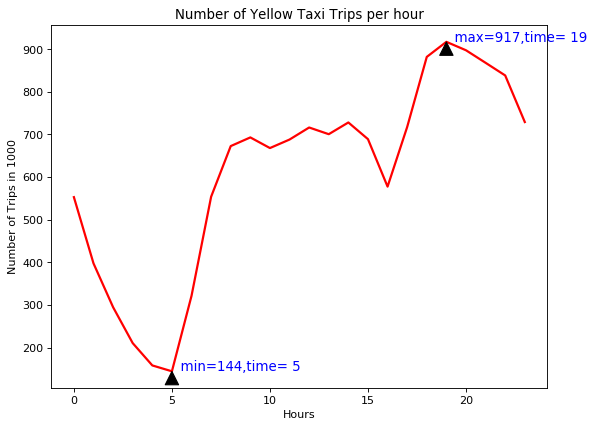

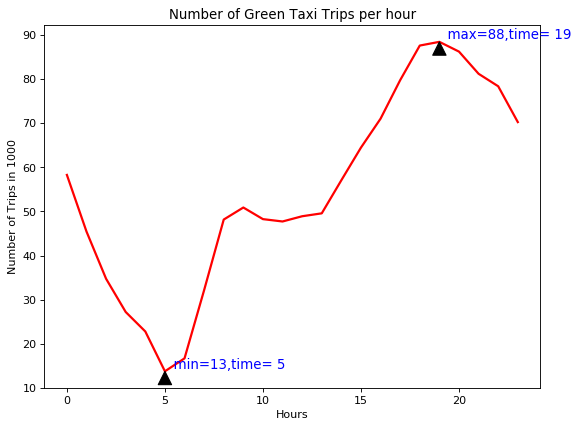

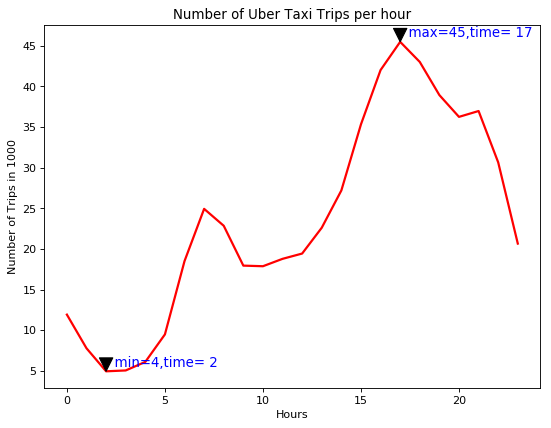

In [271]:
hours_trips(collection_yellow,collection_green,collection_uber)

In [245]:
def number_of_trips(collection_y,collection_g,collection_u):
    
    group = {
      '$group': { 
        "_id" : "$pickup_weekday", 
        'count': { 
          '$sum': 1
        } 
      }
    }
    sort = {
        '$sort': {"_id":1}
    }
    
    yellow = collection_y.aggregate([group, sort])
    day = []
    count = []
    i = 0
    for d in yellow:
        day.append(d['_id'])
        count.append(d['count'])
                
    green = collection_g.aggregate([group, sort])
    day_g = []
    count_g = []
    i = 0
    for d in green:
        day_g.append(d['_id'])
        count_g.append(d['count'])
    
    uber = collection_u.aggregate([group, sort])
    day_u = []
    count_u = []
    i = 0
    for d in uber:
        day_u.append(d['_id'])
        count_u.append(d['count'])
        
    fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.subplot(111)

    #ax.yaxis.set_major_formatter(formatter)
    ax.bar(day, formatter(count))
    plt.title('Number of Yellow Taxi Trips per day') 
    plt.xticks(day, ( 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun')) # {0,1,2,3,4,5,6}
    plt.show()
    
    fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.subplot(111)
    
    ax.bar(day_g, formatter(count_g))
    plt.title('Number of Green Taxi Trips per day') 
    plt.xticks(day_g, ( 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun')) # {0,1,2,3,4,5,6}
    plt.show()
    
    fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.subplot(111)

    #ax.yaxis.set_major_formatter(formatter)
    ax.bar(day_u, formatter(count_u))
    plt.title('Number of Uber Taxi Trips per day') 
    plt.xticks(day, ( 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun')) # {0,1,2,3,4,5,6}
    plt.show()
    return None

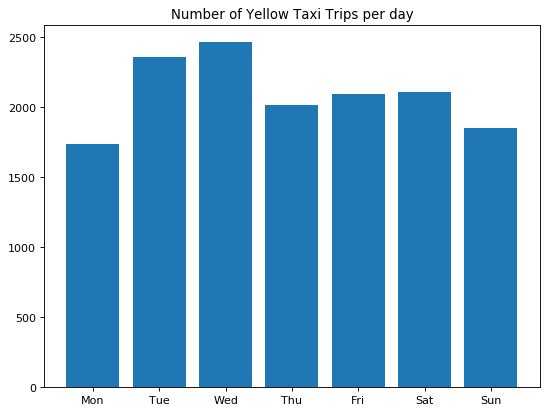

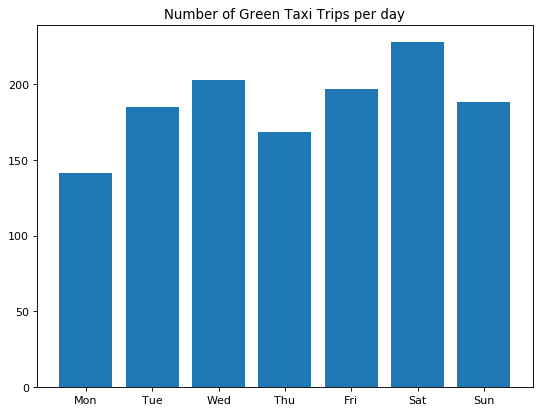

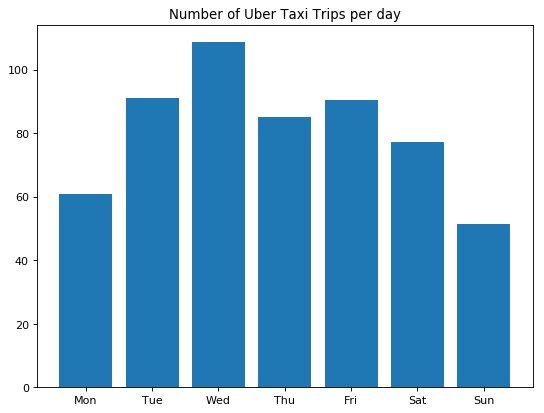

In [246]:
number_of_trips(collection_yellow,collection_green,collection_uber)

In [185]:
#from string to datetime, float, int
def add_hour_time(date_format, collection ,names,dataset):
    bulk = collection.initialize_unordered_bulk_op()
    counter = 0
    count2 = 0
    requests = []
    cursor = collection.find(modifiers={"$snapshot": True})
    for record in cursor:
        #if type(record['passenger_count']) is int:
        #    count2+=1
        #    continue
        trip_distance = float(record[names['trip_dist']])
        if trip_distance !=float(0):
            if dataset == 'green':
                pickup_datetime = datetime.strptime(record[names['pickup_datetime']],date_format)
                dropoff_datetime = datetime.strptime(record[names['dropoff_datetime']],date_format)
            else:
                pickup_datetime = record[names['pickup_datetime']]
                dropoff_datetime = record[names['dropoff_datetime']]
            seconds = (dropoff_datetime - pickup_datetime).total_seconds()
            hour = (seconds/60)/60
            if hour == float(0):
                speed_hour=-1
            else:
                speed_hour = trip_distance/hour
            
            bulk.find({'_id':record['_id']}).update({'$set':{
                                           'speed_hour' : speed_hour}})
        else: # if trip_dist <= 0
            bulk.find({'_id':record['_id']}).update({'$set':{
                                           'speed_hour' : -1}})
        counter+=1
        if counter % 1000 == 0:
            pprint(counter)
            bulk.execute()
            bulk = collection.initialize_unordered_bulk_op()
            
    if (counter % 1000 != 0):
        bulk.execute()
    pprint(counter)
    pprint(count2)
    return collection

In [186]:
names_green = {'pass_count':'Passenger_count',
                         'trip_dist':'Trip_distance',
                         'total_amount':'Total_amount',
                         'pickup_datetime':'lpep_pickup_datetime',
                        'dropoff_datetime':'Lpep_dropoff_datetime'}


date_format = '%Y-%m-%d %H:%M:%S'


add_hour_time(date_format,collection_green,names_green,'green')



/Users/fahadalms3odi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: initialize_unordered_bulk_op is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


1000
2000
3000


/Users/fahadalms3odi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: initialize_unordered_bulk_op is deprecated


4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
159000
160000
161

1166000
1167000
1168000
1169000
1170000
1171000
1172000
1173000
1174000
1175000
1176000
1177000
1178000
1179000
1180000
1181000
1182000
1183000
1184000
1185000
1186000
1187000
1188000


KeyboardInterrupt: 

In [33]:
green = collection_green.find_one()
print(green)

{'_id': ObjectId('5a50cc5884a440575f28056d'), 'lpep_pickup_datetime': '2014-04-01 00:00:00', 'Lpep_dropoff_datetime': '2014-04-01 14:24:20', 'Passenger_count': 1, 'Trip_distance': 7.45, 'Tip_amount': 0.0, 'Total_amount': 23.5, 'dropoff_Point': {'type': 'Point', 'coordinates': [0.0, 0.0]}, 'pickup_Point': {'type': 'Point', 'coordinates': [0.0, 0.0]}, 'passenger_count': 1, 'trip_distance': 7.45, 'total_amount': 23.5, 'pickup_datetime': datetime.datetime(2014, 4, 1, 0, 0), 'pickup_weekday': 1, 'dropoff_datetime': datetime.datetime(2014, 4, 1, 14, 24, 20), 'dropoff_weekday': 1, 'speed_hour': 0.5171615888931739}


In [41]:
names_yellow = {'pass_count':'passenger_count',
                         'trip_dist':'trip_distance',
                         'total_amount':'total_amount',
                         'pickup_datetime':'pickup_datetime',
                        'dropoff_datetime':'dropoff_datetime'}
date_format = '%Y-%m-%d %H:%M:%S'


add_hour_time(date_format,collection_yellow,names_yellow,'yellow')



/Users/fahadalms3odi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: initialize_unordered_bulk_op is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


1000
2000
3000
4000


/Users/fahadalms3odi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: initialize_unordered_bulk_op is deprecated


5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
159000
160000
161000
1

1168000
1169000
1170000
1171000
1172000
1173000
1174000
1175000
1176000
1177000
1178000
1179000
1180000
1181000
1182000
1183000
1184000
1185000
1186000
1187000
1188000
1189000
1190000
1191000
1192000
1193000
1194000
1195000
1196000
1197000
1198000
1199000
1200000
1201000
1202000
1203000
1204000
1205000
1206000
1207000
1208000
1209000
1210000
1211000
1212000
1213000
1214000
1215000
1216000
1217000
1218000
1219000
1220000
1221000
1222000
1223000
1224000
1225000
1226000
1227000
1228000
1229000
1230000
1231000
1232000
1233000
1234000
1235000
1236000
1237000
1238000
1239000
1240000
1241000
1242000
1243000
1244000
1245000
1246000
1247000
1248000
1249000
1250000
1251000
1252000
1253000
1254000
1255000
1256000
1257000
1258000
1259000
1260000
1261000
1262000
1263000
1264000
1265000
1266000
1267000
1268000
1269000
1270000
1271000
1272000
1273000
1274000
1275000
1276000
1277000
1278000
1279000
1280000
1281000
1282000
1283000
1284000
1285000
1286000
1287000
1288000
1289000
1290000
1291000
1292000


2196000
2197000
2198000
2199000
2200000
2201000
2202000
2203000
2204000
2205000
2206000
2207000
2208000
2209000
2210000
2211000
2212000
2213000
2214000
2215000
2216000
2217000
2218000
2219000
2220000
2221000
2222000
2223000
2224000
2225000
2226000
2227000
2228000
2229000
2230000
2231000
2232000
2233000
2234000
2235000
2236000
2237000
2238000
2239000
2240000
2241000
2242000
2243000
2244000
2245000
2246000
2247000
2248000
2249000
2250000
2251000
2252000
2253000
2254000
2255000
2256000
2257000
2258000
2259000
2260000
2261000
2262000
2263000
2264000
2265000
2266000
2267000
2268000
2269000
2270000
2271000
2272000
2273000
2274000
2275000
2276000
2277000
2278000
2279000
2280000
2281000
2282000
2283000
2284000
2285000
2286000
2287000
2288000
2289000
2290000
2291000
2292000
2293000
2294000
2295000
2296000
2297000
2298000
2299000
2300000
2301000
2302000
2303000
2304000
2305000
2306000
2307000
2308000
2309000
2310000
2311000
2312000
2313000
2314000
2315000
2316000
2317000
2318000
2319000
2320000


3224000
3225000
3226000
3227000
3228000
3229000
3230000
3231000
3232000
3233000
3234000
3235000
3236000
3237000
3238000
3239000
3240000
3241000
3242000
3243000
3244000
3245000
3246000
3247000
3248000
3249000
3250000
3251000
3252000
3253000
3254000
3255000
3256000
3257000
3258000
3259000
3260000
3261000
3262000
3263000
3264000
3265000
3266000
3267000
3268000
3269000
3270000
3271000
3272000
3273000
3274000
3275000
3276000
3277000
3278000
3279000
3280000
3281000
3282000
3283000
3284000
3285000
3286000
3287000
3288000
3289000
3290000
3291000
3292000
3293000
3294000
3295000
3296000
3297000
3298000
3299000
3300000
3301000
3302000
3303000
3304000
3305000
3306000
3307000
3308000
3309000
3310000
3311000
3312000
3313000
3314000
3315000
3316000
3317000
3318000
3319000
3320000
3321000
3322000
3323000
3324000
3325000
3326000
3327000
3328000
3329000
3330000
3331000
3332000
3333000
3334000
3335000
3336000
3337000
3338000
3339000
3340000
3341000
3342000
3343000
3344000
3345000
3346000
3347000
3348000


4252000
4253000
4254000
4255000
4256000
4257000
4258000
4259000
4260000
4261000
4262000
4263000
4264000
4265000
4266000
4267000
4268000
4269000
4270000
4271000
4272000
4273000
4274000
4275000
4276000
4277000
4278000
4279000
4280000
4281000
4282000
4283000
4284000
4285000
4286000
4287000
4288000
4289000
4290000
4291000
4292000
4293000
4294000
4295000
4296000
4297000
4298000
4299000
4300000
4301000
4302000
4303000
4304000
4305000
4306000
4307000
4308000
4309000
4310000
4311000
4312000
4313000
4314000
4315000
4316000
4317000
4318000
4319000
4320000
4321000
4322000
4323000
4324000
4325000
4326000
4327000
4328000
4329000
4330000
4331000
4332000
4333000
4334000
4335000
4336000
4337000
4338000
4339000
4340000
4341000
4342000
4343000
4344000
4345000
4346000
4347000
4348000
4349000
4350000
4351000
4352000
4353000
4354000
4355000
4356000
4357000
4358000
4359000
4360000
4361000
4362000
4363000
4364000
4365000
4366000
4367000
4368000
4369000
4370000
4371000
4372000
4373000
4374000
4375000
4376000


5279000
5280000
5281000
5282000
5283000
5284000
5285000
5286000
5287000
5288000
5289000
5290000
5291000
5292000
5293000
5294000
5295000
5296000
5297000
5298000
5299000
5300000
5301000
5302000
5303000
5304000
5305000
5306000
5307000
5308000
5309000
5310000
5311000
5312000
5313000
5314000
5315000
5316000
5317000
5318000
5319000
5320000
5321000
5322000
5323000
5324000
5325000
5326000
5327000
5328000
5329000
5330000
5331000
5332000
5333000
5334000
5335000
5336000
5337000
5338000
5339000
5340000
5341000
5342000
5343000
5344000
5345000
5346000
5347000
5348000
5349000
5350000
5351000
5352000
5353000
5354000
5355000
5356000
5357000
5358000
5359000
5360000
5361000
5362000
5363000
5364000
5365000
5366000
5367000
5368000
5369000
5370000
5371000
5372000
5373000
5374000
5375000
5376000
5377000
5378000
5379000
5380000
5381000
5382000
5383000
5384000
5385000
5386000
5387000
5388000
5389000
5390000
5391000
5392000
5393000
5394000
5395000
5396000
5397000
5398000
5399000
5400000
5401000
5402000
5403000


6306000
6307000
6308000
6309000
6310000
6311000
6312000
6313000
6314000
6315000
6316000
6317000
6318000
6319000
6320000
6321000
6322000
6323000
6324000
6325000
6326000
6327000
6328000
6329000
6330000
6331000
6332000
6333000
6334000
6335000
6336000
6337000
6338000
6339000
6340000
6341000
6342000
6343000
6344000
6345000
6346000
6347000
6348000
6349000
6350000
6351000
6352000
6353000
6354000
6355000
6356000
6357000
6358000
6359000
6360000
6361000
6362000
6363000
6364000
6365000
6366000
6367000
6368000
6369000
6370000
6371000
6372000
6373000
6374000
6375000
6376000
6377000
6378000
6379000
6380000
6381000
6382000
6383000
6384000
6385000
6386000
6387000
6388000
6389000
6390000
6391000
6392000
6393000
6394000
6395000
6396000
6397000
6398000
6399000
6400000
6401000
6402000
6403000
6404000
6405000
6406000
6407000
6408000
6409000
6410000
6411000
6412000
6413000
6414000
6415000
6416000
6417000
6418000
6419000
6420000
6421000
6422000
6423000
6424000
6425000
6426000
6427000
6428000
6429000
6430000


7331000
7332000
7333000
7334000
7335000
7336000
7337000
7338000
7339000
7340000
7341000
7342000
7343000
7344000
7345000
7346000
7347000
7348000
7349000
7350000
7351000
7352000
7353000
7354000
7355000
7356000
7357000
7358000
7359000
7360000
7361000
7362000
7363000
7364000
7365000
7366000
7367000
7368000
7369000
7370000
7371000
7372000
7373000
7374000
7375000
7376000
7377000
7378000
7379000
7380000
7381000
7382000
7383000
7384000
7385000
7386000
7387000
7388000
7389000
7390000
7391000
7392000
7393000
7394000
7395000
7396000
7397000
7398000
7399000
7400000
7401000
7402000
7403000
7404000
7405000
7406000
7407000
7408000
7409000
7410000
7411000
7412000
7413000
7414000
7415000
7416000
7417000
7418000
7419000
7420000
7421000
7422000
7423000
7424000
7425000
7426000
7427000
7428000
7429000
7430000
7431000
7432000
7433000
7434000
7435000
7436000
7437000
7438000
7439000
7440000
7441000
7442000
7443000
7444000
7445000
7446000
7447000
7448000
7449000
7450000
7451000
7452000
7453000
7454000
7455000


8358000
8359000
8360000
8361000
8362000
8363000
8364000
8365000
8366000
8367000
8368000
8369000
8370000
8371000
8372000
8373000
8374000
8375000
8376000
8377000
8378000
8379000
8380000
8381000
8382000
8383000
8384000
8385000
8386000
8387000
8388000
8389000
8390000
8391000
8392000
8393000
8394000
8395000
8396000
8397000
8398000
8399000
8400000
8401000
8402000
8403000
8404000
8405000
8406000
8407000
8408000
8409000
8410000
8411000
8412000
8413000
8414000
8415000
8416000
8417000
8418000
8419000
8420000
8421000
8422000
8423000
8424000
8425000
8426000
8427000
8428000
8429000
8430000
8431000
8432000
8433000
8434000
8435000
8436000
8437000
8438000
8439000
8440000
8441000
8442000
8443000
8444000
8445000
8446000
8447000
8448000
8449000
8450000
8451000
8452000
8453000
8454000
8455000
8456000
8457000
8458000
8459000
8460000
8461000
8462000
8463000
8464000
8465000
8466000
8467000
8468000
8469000
8470000
8471000
8472000
8473000
8474000
8475000
8476000
8477000
8478000
8479000
8480000
8481000
8482000


9385000
9386000
9387000
9388000
9389000
9390000
9391000
9392000
9393000
9394000
9395000
9396000
9397000
9398000
9399000
9400000
9401000
9402000
9403000
9404000
9405000
9406000
9407000
9408000
9409000
9410000
9411000
9412000
9413000
9414000
9415000
9416000
9417000
9418000
9419000
9420000
9421000
9422000
9423000
9424000
9425000
9426000
9427000
9428000
9429000
9430000
9431000
9432000
9433000
9434000
9435000
9436000
9437000
9438000
9439000
9440000
9441000
9442000
9443000
9444000
9445000
9446000
9447000
9448000
9449000
9450000
9451000
9452000
9453000
9454000
9455000
9456000
9457000
9458000
9459000
9460000
9461000
9462000
9463000
9464000
9465000
9466000
9467000
9468000
9469000
9470000
9471000
9472000
9473000
9474000
9475000
9476000
9477000
9478000
9479000
9480000
9481000
9482000
9483000
9484000
9485000
9486000
9487000
9488000
9489000
9490000
9491000
9492000
9493000
9494000
9495000
9496000
9497000
9498000
9499000
9500000
9501000
9502000
9503000
9504000
9505000
9506000
9507000
9508000
9509000


10365000
10366000
10367000
10368000
10369000
10370000
10371000
10372000
10373000
10374000
10375000
10376000
10377000
10378000
10379000
10380000
10381000
10382000
10383000
10384000
10385000
10386000
10387000
10388000
10389000
10390000
10391000
10392000
10393000
10394000
10395000
10396000
10397000
10398000
10399000
10400000
10401000
10402000
10403000
10404000
10405000
10406000
10407000
10408000
10409000
10410000
10411000
10412000
10413000
10414000
10415000
10416000
10417000
10418000
10419000
10420000
10421000
10422000
10423000
10424000
10425000
10426000
10427000
10428000
10429000
10430000
10431000
10432000
10433000
10434000
10435000
10436000
10437000
10438000
10439000
10440000
10441000
10442000
10443000
10444000
10445000
10446000
10447000
10448000
10449000
10450000
10451000
10452000
10453000
10454000
10455000
10456000
10457000
10458000
10459000
10460000
10461000
10462000
10463000
10464000
10465000
10466000
10467000
10468000
10469000
10470000
10471000
10472000
10473000
10474000
10475000
1

11279000
11280000
11281000
11282000
11283000
11284000
11285000
11286000
11287000
11288000
11289000
11290000
11291000
11292000
11293000
11294000
11295000
11296000
11297000
11298000
11299000
11300000
11301000
11302000
11303000
11304000
11305000
11306000
11307000
11308000
11309000
11310000
11311000
11312000
11313000
11314000
11315000
11316000
11317000
11318000
11319000
11320000
11321000
11322000
11323000
11324000
11325000
11326000
11327000
11328000
11329000
11330000
11331000
11332000
11333000
11334000
11335000
11336000
11337000
11338000
11339000
11340000
11341000
11342000
11343000
11344000
11345000
11346000
11347000
11348000
11349000
11350000
11351000
11352000
11353000
11354000
11355000
11356000
11357000
11358000
11359000
11360000
11361000
11362000
11363000
11364000
11365000
11366000
11367000
11368000
11369000
11370000
11371000
11372000
11373000
11374000
11375000
11376000
11377000
11378000
11379000
11380000
11381000
11382000
11383000
11384000
11385000
11386000
11387000
11388000
11389000
1

12193000
12194000
12195000
12196000
12197000
12198000
12199000
12200000
12201000
12202000
12203000
12204000
12205000
12206000
12207000
12208000
12209000
12210000
12211000
12212000
12213000
12214000
12215000
12216000
12217000
12218000
12219000
12220000
12221000
12222000
12223000
12224000
12225000
12226000
12227000
12228000
12229000
12230000
12231000
12232000
12233000
12234000
12235000
12236000
12237000
12238000
12239000
12240000
12241000
12242000
12243000
12244000
12245000
12246000
12247000
12248000
12249000
12250000
12251000
12252000
12253000
12254000
12255000
12256000
12257000
12258000
12259000
12260000
12261000
12262000
12263000
12264000
12265000
12266000
12267000
12268000
12269000
12270000
12271000
12272000
12273000
12274000
12275000
12276000
12277000
12278000
12279000
12280000
12281000
12282000
12283000
12284000
12285000
12286000
12287000
12288000
12289000
12290000
12291000
12292000
12293000
12294000
12295000
12296000
12297000
12298000
12299000
12300000
12301000
12302000
12303000
1

13107000
13108000
13109000
13110000
13111000
13112000
13113000
13114000
13115000
13116000
13117000
13118000
13119000
13120000
13121000
13122000
13123000
13124000
13125000
13126000
13127000
13128000
13129000
13130000
13131000
13132000
13133000
13134000
13135000
13136000
13137000
13138000
13139000
13140000
13141000
13142000
13143000
13144000
13145000
13146000
13147000
13148000
13149000
13150000
13151000
13152000
13153000
13154000
13155000
13156000
13157000
13158000
13159000
13160000
13161000
13162000
13163000
13164000
13165000
13166000
13167000
13168000
13169000
13170000
13171000
13172000
13173000
13174000
13175000
13176000
13177000
13178000
13179000
13180000
13181000
13182000
13183000
13184000
13185000
13186000
13187000
13188000
13189000
13190000
13191000
13192000
13193000
13194000
13195000
13196000
13197000
13198000
13199000
13200000
13201000
13202000
13203000
13204000
13205000
13206000
13207000
13208000
13209000
13210000
13211000
13212000
13213000
13214000
13215000
13216000
13217000
1

14021000
14022000
14023000
14024000
14025000
14026000
14027000
14028000
14029000
14030000
14031000
14032000
14033000
14034000
14035000
14036000
14037000
14038000
14039000
14040000
14041000
14042000
14043000
14044000
14045000
14046000
14047000
14048000
14049000
14050000
14051000
14052000
14053000
14054000
14055000
14056000
14057000
14058000
14059000
14060000
14061000
14062000
14063000
14064000
14065000
14066000
14067000
14068000
14069000
14070000
14071000
14072000
14073000
14074000
14075000
14076000
14077000
14078000
14079000
14080000
14081000
14082000
14083000
14084000
14085000
14086000
14087000
14088000
14089000
14090000
14091000
14092000
14093000
14094000
14095000
14096000
14097000
14098000
14099000
14100000
14101000
14102000
14103000
14104000
14105000
14106000
14107000
14108000
14109000
14110000
14111000
14112000
14113000
14114000
14115000
14116000
14117000
14118000
14119000
14120000
14121000
14122000
14123000
14124000
14125000
14126000
14127000
14128000
14129000
14130000
14131000
1

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'DB_2014_04'), 'yellow_2014_04')

In [168]:
def Day_name(x):
    return {
        0: 'Mon',
        1: 'Tue',
        2: 'Wed',
        3: 'Thu',
        4: 'Fri',
        5: 'Sat',
        6: 'Sun',
    }[x]


def speed_per_hours(collection_y,collection_g):
    green = collection_g.aggregate(
       [
         {
           '$project':
             {
               'hours': { '$hour': "$pickup_datetime" },
               'speed_hour':1 ,
               'pickup_weekday':1 
             }
         },
            { '$group' : {'_id': {'day' : '$pickup_weekday', 'hour_day' :'$hours'},'speed':{"$avg": '$speed_hour'}} },
           {'$sort' : {'_id': 1}}
       ]
    )
    
        
    green_dict = {}
    green_list =[]
    day_g =[]
    hour_g =[]
    i = 0
    current_day = 0
    
  

    for d in green:
        if i == d['_id']['day']:
            green_list.append( (d['_id']['hour_day'],d['speed'] ) )
            current_day = d['_id']['day']
        else:
            if len(green_list)==0:
                i =i +1
            else:
                green_dict[Day_name(current_day)] = green_list
                green_list = []
                green_list.append((d['_id']['hour_day'],d['speed'] ) )
                i = d['_id']['day']
    if len(green_list)!=0:
        green_dict[Day_name(current_day)] = green_list

    fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.subplot(111)
    
    hours_list =[]
    speed_list = []
    colours=['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for key, value in green_dict.items():
        list_day = value
        list_day.sort()
        for x in list_day:
            hours_list.append(x[0])
            speed_list.append(x[1])
        #hours_list.sort()
        #speed_list.sort()
        ax.plot(hours_list,speed_list,colours.pop(),label=key ,linewidth=2.0)
        #ymax = max(speed_list)
        #xpos = speed_list.index(ymax)
        #xmax = hours_list[xpos]
        #ax.annotate(math.floor(ymax), xy=(xmax, ymax), xytext=(xmax, ymax+0.3)) 
        hours_list=[]
        speed_list = []
        
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Time(24h)')
    plt.ylabel('Miles per hour (mph)')
    plt.title('the average speed of green taxi in miles per hour') 

    plt.show()
    
    
    yellow = collection_y.aggregate(
       [
         {
           '$project':
             {
               'hours': { '$hour': "$pickup_datetime" },
               'speed_hour':1 ,
               'pickup_weekday':1 
             }
         },
            { '$group' : {'_id': {'day' : '$pickup_weekday', 'hour_day' :'$hours'},'speed':{"$avg": '$speed_hour'}} },
           {'$sort' : {'_id': 1}}
       ]
    )
    
    
    yellow_dict = {}
    yellow_list =[]
    day_y =[]
    hour_y =[]
    i = 0
    current_day = 0
    
  

    for d in yellow:
        if i == d['_id']['day']:
            yellow_list.append( (d['_id']['hour_day'],d['speed'] ) )
            current_day = d['_id']['day']
        else:
            if len(yellow_list)==0:
                i =i +1
            else:
                yellow_dict[Day_name(current_day)] = yellow_list
                yellow_list = []
                yellow_list.append((d['_id']['hour_day'],d['speed'] ) )
                i = d['_id']['day']
    if len(yellow_list)!=0:
        yellow_dict[Day_name(current_day)] = yellow_list

    fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax = plt.subplot(111)
    
    hours_list =[]
    speed_list = []
    colours=['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for key, value in yellow_dict.items():
        list_day = value
        list_day.sort()
        for x in list_day:
            hours_list.append(x[0])
            speed_list.append(x[1])
        #hours_list.sort()
        #speed_list.sort()
        ax.plot(hours_list,speed_list,colours.pop(),label=key ,linewidth=2.0)
        hours_list=[]
        speed_list = []
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Time(24h)')
    plt.ylabel('Miles per hour (mph)')
    plt.title('the average speed of yellow taxi in miles per hour')
    plt.show()


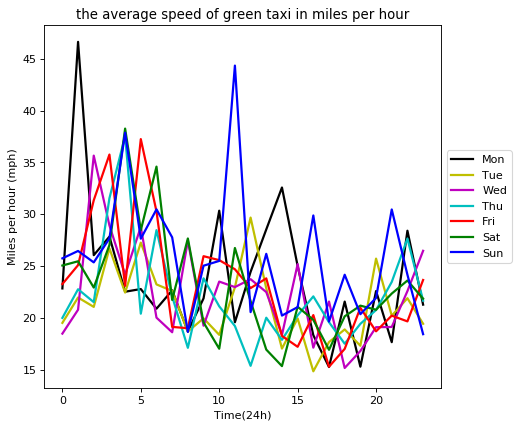

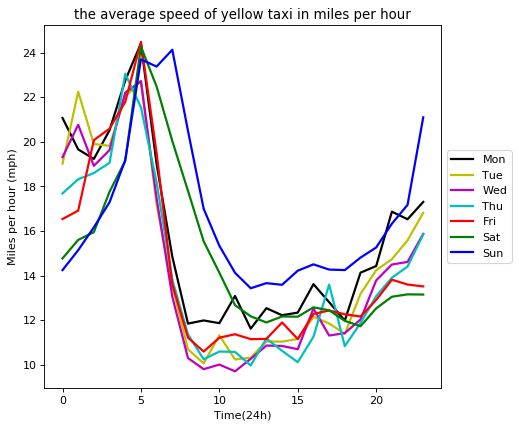

In [169]:
import matplotlib.pyplot as plt
import math

speed_per_hours(collection_yellow,collection_green)